In [2]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import glob
import os
import re
import seaborn as sns
import spacy
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import en_core_web_sm
import re
import datetime
from afinn import Afinn
import matplotlib.pyplot as plt
tqdm.pandas()
import scipy as sc

nlp = spacy.load("en_core_web_sm")

This notebook consists of two parts:
- analysis of the quotes related to the top movies
- some visualisations

## Text Analysis

In [162]:
# load the quotes that we relate to the top 50 movies
quotes = pd.read_csv("../data/50moviesquotes.csv.gz")

The first cleaning stage will consit in removing from the quotes the title of the movies (otherwise the study will have a high bias)

In [144]:
alttitles = dict([
    ('Star Wars: Episode VII - The Force Awakens', ['Star Wars', 'The force awakens']),
    ('Avengers: Endgame', ['Avengers', 'Endgame']),
    ('Black Panther', ['Black Panther']),
    ('Avengers: Infinity War', ['Infinity War', 'Avengers']),
    ('Jurassic World', ['Jurassic']), # Probably a bad idea but let's see
    ('Star Wars: Episode VIII - The Last Jedi', ['Star Wars', 'Last Jedi']),
    ('Incredibles 2', ['Incredibles']), # Possibly too broad
    ('The Lion King', ['Lion King']),
    ('Rogue One: A Star Wars Story', ['Rogue One', 'Star Wars']),
    ('Star Wars: Episode IX - The Rise of Skywalker', ['Star Wars', 'Skywalker']),
    ('Beauty and the Beast', ['Beauty and the Beast']),
    ('Finding Dory', ['Finding Dory']),
    ('Frozen II', ['Frozen']), # Probably a bad idea but let's see
    ('Avengers: Age of Ultron', ['Avengers', 'Ultron']),
    ('Toy Story 4', ['Toy Story']),
    ('Captain Marvel', ['Marvel']),
    ('Jurassic World: Fallen Kingdom', ['Jurassic', 'Fallen Kingdom']),
    ('Captain America: Civil War', ['Captain America', 'Civil War']),
    ('Jumanji: Welcome to the Jungle', ['Jumanji', 'Welcome to the Jungle']),
    #('Spider-Man: Far from Home', ['Spider-Man', 'Spider Man', 'Far from Home']),
    ('Guardians of the Galaxy Vol. 2', ['Guardians of the Galaxy']),
    ('The Secret Life of Pets', ['Secret Life of Pets']),
    ('The Jungle Book', ['Jungle Book']),
    ('Deadpool', ['Deadpool']),
    ('Inside Out', ['Inside Out']),
    ('Aladdin', ['Aladdin']),
    ('Furious 7', ['Furious']), # Probably a bad idea but let's see
    ('American Sniper', ['American Sniper']),
    ('Zootopia', ['Zootopia']),
    ('The Hunger Games: Mockingjay - Part 1', ['Hunger Games', 'Mockingjay']),
    ('Minions', ['Minions']), # Possibly too broad
    ('Joker', ['Joker']),
    ('Aquaman', ['Aquaman']),
    ('Spider-Man: Homecoming', ['Spider-Man', 'Spider Man', 'Homecoming']),
    ('Batman v Superman: Dawn of Justice', ['Batman', 'Superman', 'Dawn of Justice']),
    #('It', []), # just not possible
    ('Suicide Squad', ['Suicide Squad']),
    ('Jumanji: The Next Level', ['Jumanji', 'The Next Level']),
    ('Deadpool 2', ['Deadpool']),
    ('Thor: Ragnarok', ['Thor', 'Ragnarok']),
    ('The Hunger Games: Mockingjay - Part 2', ['Hunger Games', 'Mockingjay']),
    ('The Grinch', ['Grinch']),
    ('Sing', ['Sing']), # Probably a bad idea but let's see
    ('Despicable Me 3', ['Despicable Me']),
    ('The Hobbit: The Battle of the Five Armies', ['Hobbit', 'Battle of the Five Armies']),
    ('Moana', ['Moana']),
    ('Fantastic Beasts and Where to Find Them', ['Fantastic Beasts']),
    ('Doctor Strange', ['Doctor Strange']),
    ('Justice League', ['Justice League'])
])

In [145]:
# remove title and search keys from quotations
for movie in alttitles:
    for strt in alttitles[movie]:
        val = quotes.loc[quotes["primaryTitle"]==movie]["quotation"].str.replace(strt, '',case=False)
        quotes.loc[quotes["primaryTitle"]==movie,"quotation"] = val

Cleaning the movie data set

In [146]:
# boxoffice see movieBoxOffice.ipynb to generate the dataset
boxoffice = pd.read_csv("../data/boxoffice.csv")
boxoffice["boxoffice"] = boxoffice["Gross"].apply(lambda x:int(x.replace("$","").replace(",","")))
boxoffice["% of Total"] = pd.to_numeric(boxoffice["% of Total"].str.replace("%",""),errors="coerce")

Merging quotes and boxoffice data

In [147]:
# merge quotes and boxoffice
quotes = pd.merge(left=quotes,right=boxoffice,how="left",left_on="primaryTitle",right_on="Release")
# add a field to count days between quote and release date
quotes["diff_date"] = (pd.to_datetime(quotes["date"]) - pd.to_datetime(quotes["Release Date"])).dt.days
# only keep around a window
DELTA_T = 10
quotes = quotes[(quotes["diff_date"]<DELTA_T)&(quotes["diff_date"]>-DELTA_T)]

## Sentiment polarity

In [149]:
afn = Afinn()

nlp = en_core_web_sm.load()

punctuations = string.punctuation
#stopwords = list(STOP_WORDS)

parser = nlp
def spacy_tokenizer(sentence):
    tokens = parser(sentence)
    tokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens ]
    tokens = [ word for word in tokens if word not in punctuations ]
    tokens = " ".join([i for i in tokens])
    return tokens

def count_words(s):
    return len(s.split())

def sentiment(s):
    return afn.score(s)

In [150]:
# long to run ! (15min?)
quotes["text_clean"] = quotes["quotation"].apply(spacy_tokenizer)
quotes["text"] = quotes["text_clean"].astype('str')

In [151]:
quotes["sentiment"] = quotes["text"].apply(sentiment)
quotes["word_counts"] = quotes["text"].apply(count_words)

In [200]:
quotes.to_csv("../data/50movies_sentiment_polarity.csv.gz",compression="gzip")

### Emotion Analysis

In [152]:
# long to run ! (25min?)

from empath import Empath
lexicon = Empath()
categories = ["warmth", "fun","love","emotional", "disappointment","hate"]
results=[]
analysis = pd.DataFrame(columns=["primaryTitle","% of Total","sentiment","score"])
for index, row in quotes.iterrows():
    experience = lexicon.analyze(row["text"],categories = categories)
    for cat in experience:
        analysis = analysis.append({"primaryTitle":row["primaryTitle"],"% of Total":row["% of Total"],"sentiment":cat,"score":experience[cat]},ignore_index=True)
analysis.head(10)


,primaryTitle,% of Total,sentiment,score
0,Star Wars: Episode VII - The Force Awakens,26.5,warmth,0.0
1,Star Wars: Episode VII - The Force Awakens,26.5,fun,0.0
2,Star Wars: Episode VII - The Force Awakens,26.5,emotional,0.0
3,Star Wars: Episode VII - The Force Awakens,26.5,disappointment,0.0
4,Star Wars: Episode VII - The Force Awakens,26.5,love,0.0
5,Star Wars: Episode VII - The Force Awakens,26.5,hate,0.0
6,Star Wars: Episode VII - The Force Awakens,26.5,warmth,0.0
7,Star Wars: Episode VII - The Force Awakens,26.5,fun,0.0
8,Star Wars: Episode VII - The Force Awakens,26.5,emotional,0.0
9,Star Wars: Episode VII - The Force Awakens,26.5,disappointment,0.0


In [157]:
analysis.to_csv("../data/50movies_sentiment_emotion.csv.gz",compression="gzip")

### PLOTS

Reload the data since previous stages are time consuming (40min)

In [143]:
# boxoffice see movieBoxOffice.ipynb to generate the dataset
boxoffice = pd.read_csv("../data/boxoffice.csv")
boxoffice["boxoffice"] = boxoffice["Gross"].apply(lambda x:int(x.replace("$","").replace(",","")))
boxoffice["% of Total"] = pd.to_numeric(boxoffice["% of Total"].str.replace("%",""),errors="coerce")

analysis = pd.read_csv("../data/50movies_sentiment_emotion.csv.gz")
polarity = pd.read_csv("../data/50movies_sentiment_polarity.csv.gz")

# remove irrelevant case
analysis = analysis[analysis["primaryTitle"]!="Sing"]
polarity = polarity[polarity["primaryTitle"]!="Sing"]


### Emotion analysis

1. Split the movies into 3 categories

In [144]:
# split movies into 3 categories
name1 = "high % first WE"
name2 = "intermediate score"
name3 = "high % after first WE"
boxoffice["category"] = (boxoffice["% of Total"]<(boxoffice["% of Total"].quantile(q=1/3)))*1+(boxoffice["% of Total"]<(boxoffice["% of Total"].quantile(q=2/3)))*1

boxoffice.loc[boxoffice["category"]==0,"category"] = name1
boxoffice.loc[boxoffice["category"]==1,"category"] = name2
boxoffice.loc[boxoffice["category"]==2,"category"] = name3

# aggregate by movie and sentiment type
analysis2 = analysis.groupby(["primaryTitle","sentiment"]).agg(score=("score","mean"),count=("primaryTitle","count")).reset_index()
analysis2 = analysis2[analysis2["count"]>20]

# incorporate movie data
analysis3 = pd.merge(left=analysis2,right=boxoffice[["Release","category"]],how="left",left_on="primaryTitle",right_on="Release")

2. Plot average score of various sentiment types

p-value for the t-test for warmth: 0.592131173903326
p-value for the t-test for fun: 0.6638467443455023
p-value for the t-test for love: 0.10946665795321267
p-value for the t-test for emotional: 0.07206539961741787
p-value for the t-test for disappointment: 0.8743080913466437
p-value for the t-test for hate: 0.03356945471767731


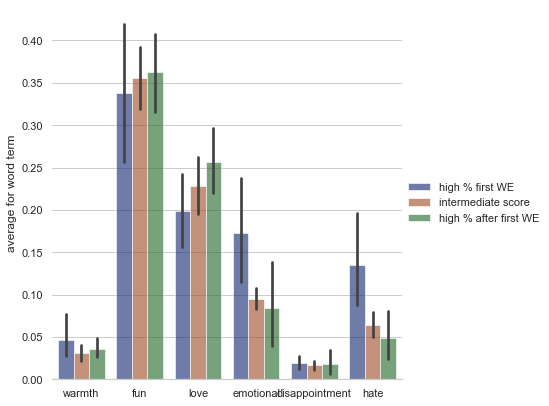

In [165]:
# plot
sns.set_theme(style="whitegrid")

analysis3.sort_values("category")
g = sns.catplot(
    data=analysis3, kind="bar",x="sentiment",y="score",hue="category",
    palette="dark", alpha=.6, height=6,hue_order=[name1,name2,name3],order=categories
)
g.despine(left=True)
g.set_axis_labels("", "average for word term")
g.legend.set_title("")
plt.savefig("./figures/sentiementAnalysis.pdf")
plt.savefig("./figures/sentiementAnalysis.png")

# t-test
for cat in categories:
    a1 = analysis3[(analysis3["sentiment"]==cat)&(analysis3["category"]==name1)]["score"]
    a2 = analysis3[(analysis3["sentiment"]==cat)&(analysis3["category"]==name3)]["score"]
    res = sc.stats.ttest_ind(a1,a2)
    print(f"p-value for the t-test for {cat}: {res[1]}")

### Polarity

1. Relation to the total gross

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


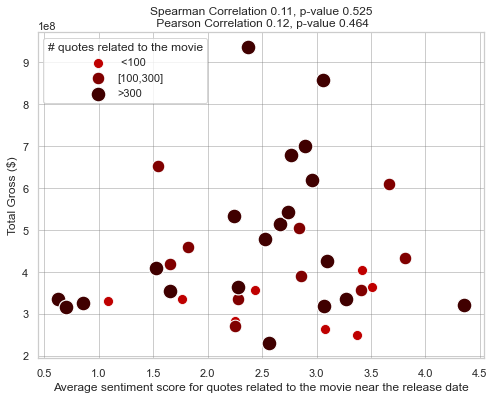

In [164]:
plt.figure(figsize=(8,6))
quotes_gr2 = polarity.groupby("primaryTitle").agg(boxoffice=("boxoffice","first"),sentiment=("sentiment","mean"),count=("boxoffice","count")).reset_index()
quotes_gr2 = quotes_gr2[quotes_gr2["count"]>20]
cmap = np.array([(3,0,0),(2,0,0),(1,0,0)])/4
s1 = 100
s2 = 300
quotes_gr2["cat"] = (quotes_gr2["count"]<s1)*0+(quotes_gr2["count"]>=s1)*1 + (quotes_gr2["count"]>s2)*1
labels = [f" <{s1}",f"[{s1},{s2}]",f">{s2}"]
quotes_gr2.sort_values("cat")

for i in range(3):
    sns.scatterplot(data=quotes_gr2[quotes_gr2["cat"]==i],x="sentiment",y="boxoffice",s=(i)*60+100,alpha=1,label=labels[i],c=cmap[i])

plt.xlabel("Average sentiment score for quotes related to the movie near the release date")
plt.ylabel("Total Gross ($)")
a1 = sc.stats.spearmanr(quotes_gr2["sentiment"],quotes_gr2["boxoffice"])
b1 = sc.stats.pearsonr(quotes_gr2["sentiment"],quotes_gr2["boxoffice"])
plt.title(f"Spearman Correlation {a1[0]:.2}, p-value {a1[1]:.3}\n Pearson Correlation {b1[0]:.2}, p-value {b1[1]:.3}")
plt.savefig("./figures/polarityAnalysis_totalGross.pdf")
plt.savefig("./figures/polarityAnalysis_totalGross.png")
plt.legend(title='# quotes related to the movie')
plt.grid(which='major', color='gray',alpha=0.4, linestyle='-')


2. Relation to perccentage of gross achieved on the first WE

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


(0.0, 5.0)

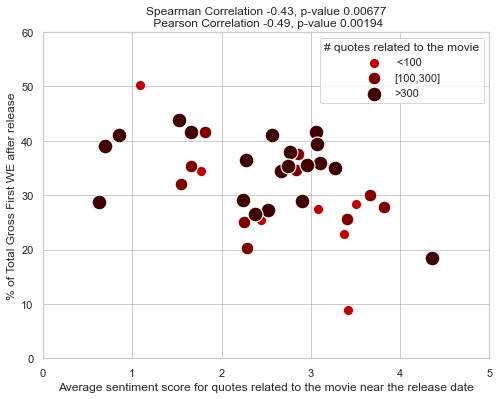

In [163]:
quotes_gr1 = polarity[(polarity["primaryTitle"]!="Sing")].groupby("primaryTitle").agg(percent=("% of Total","first"),sentiment=("sentiment","mean"),count=("sentiment","count"),boxoffice=("boxoffice","first")).reset_index()
quotes_gr1 = quotes_gr1[quotes_gr1["count"]>20]
cmap = np.array([(3,0,0),(2,0,0),(1,0,0)])/4
s1 = 100
s2 = 300
quotes_gr1["cat"] = (quotes_gr1["count"]<s1)*0+(quotes_gr1["count"]>=s1)*1 + (quotes_gr1["count"]>s2)*1
labels = [f" <{s1}",f"[{s1},{s2}]",f">{s2}"]
quotes_gr1.sort_values("cat")

plt.figure(figsize=(8,6))
for i in range(3):
    sns.scatterplot(data=quotes_gr1[quotes_gr1["cat"]==i],x="sentiment",y="percent",s=(i)*60+100,alpha=1,label=labels[i],c=cmap[i])

plt.xlabel("Average sentiment score for quotes related to the movie near the release date")
plt.ylabel("% of Total Gross First WE after release")
a1 = sc.stats.spearmanr(quotes_gr1["sentiment"],quotes_gr1["percent"])
b1 = sc.stats.pearsonr(quotes_gr1["sentiment"],quotes_gr1["percent"])
plt.title(f"Spearman Correlation {a1[0]:.2}, p-value {a1[1]:.3}\n Pearson Correlation {b1[0]:.2}, p-value {b1[1]:.3}")
plt.savefig("./figures/polarityAnalysis_percentGross.pdf")
plt.savefig("./figures/polarityAnalysis_percentGross.png")
plt.legend(title='# quotes related to the movie')
plt.grid(which='major', color='gray',alpha=0.4, linestyle='-')
plt.ylim(0,60)
plt.xlim(0,5)